# Tidy Tuesday - Predicting boardgame ratings


In January 2022, the R Tidy Tuesday featured a dataset of boardgame ratings from BoardGameGeek.com. In this notebook, we will investigate how easily a boardgame's (average) rating can be predicted using the game's characteristics.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

In [6]:
#plt.style.use('ggplot')


In [3]:
ratings = pd.read_csv("ratings.csv")
details = pd.read_csv("details.csv")

For this exercise, let's split the dataset into a training set, consisting of 80% of the entries, and a test set, consisting of 20%.

In [4]:
training_data, test_data = train_test_split(ratings,
                                            shuffle = True,
                                            test_size = 0.2,
                                            random_state = 2023)

Before we start modeling, let's have a quick run-through of the variables available in the dataset.

### The target variable

We will attempt to predict for each boardgame the variable entitled "average", which represents the average of BGG users' ratings for the boardgame, on a scale of 1 to 10.

The plot below shows the distribution of ratings in the training data.

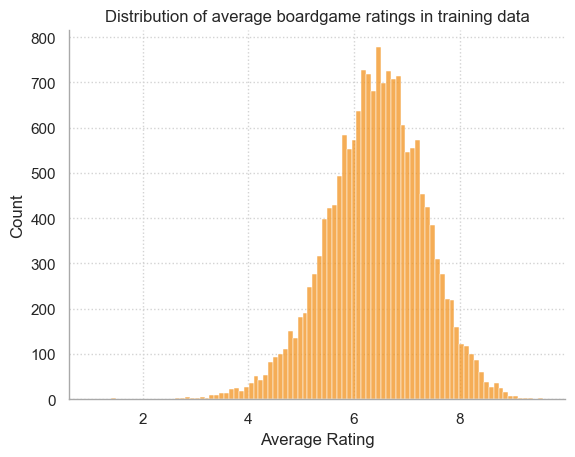

In [29]:
#plt.grid(color = "gray")
with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0}):
    p1 = sns.histplot(data = training_data, x = "average", color = "#F2921D").set(
        title = "Distribution of average boardgame ratings in training data",
        xlabel = "Average Rating")


### Other variables

The dataset comes in two files, *ratings.csv* and *details.csv*. In both files, a row corresponds to a single board game, so the two files can be easily merged. The table below summarizes the number of observations in the training and test sets. Since we will rely on variables in *details.csv* for our predictions, we will have to deal separately with games without a corresponding entry in *details.csv*.

In [30]:
n_train_ratings = len(training_data)
n_test_ratings = len(test_data)

train_details = training_data.merge(details, on = "id")
n_train_w_details = len(train_details)
test_details = test_data.merge(details, on = "id")
n_test_w_details = len(test_details)

n_obs_table = pd.DataFrame({
    "Table" : ["Training (ratings)", "Training (details)", "Test (ratings)", "Test (details)"],
    "Number of observations": [n_train_ratings, n_train_w_details, n_test_ratings, n_test_w_details]
})
n_obs_table


,Table,Number of observations
0,Training (ratings),17464
1,Training (details),17311
2,Test (ratings),4367
3,Test (details),4320


In [31]:
train_details["test"] = 0
test_details["test"] = 1
combined_details = pd.concat([train_details, test_details], axis = 0)
#combined_details.shape

Next, let's plot rating as a function of various potential features (`yearpublished`, `minplayers`, `maxplayers`, `playingtime`, and designer and publisher variables).

### Number of players

We will treat the player-number features as categorical, since they are small and integer-valued.

In [79]:
mpl.rcParams["text.color"]

'.15'

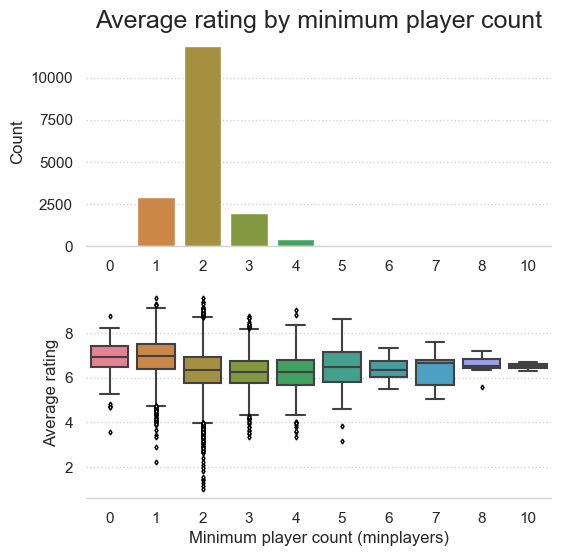

In [83]:

flierprops = dict(marker='d',
                  markerfacecolor='white',
                  markeredgecolor = 'black',
                  markersize=2.5)
palette = sns.color_palette("husl", 11)

with mpl.rc_context({'text.color': '.15',
                    'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : False,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'lightgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': '.15'}):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()
    
    p1 = sns.countplot(ax = ax[0], data = train_details, x = "minplayers",
                      palette = palette)
    p2 = sns.boxplot(ax = ax[1],
                     data = train_details,
                     x = "minplayers",
                     y = "average",
                     flierprops = flierprops,
                     palette = palette)
    temp = p1.set(title = "Average rating by minimum player count", xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Minimum player count (minplayers)", ylabel = "Average rating")

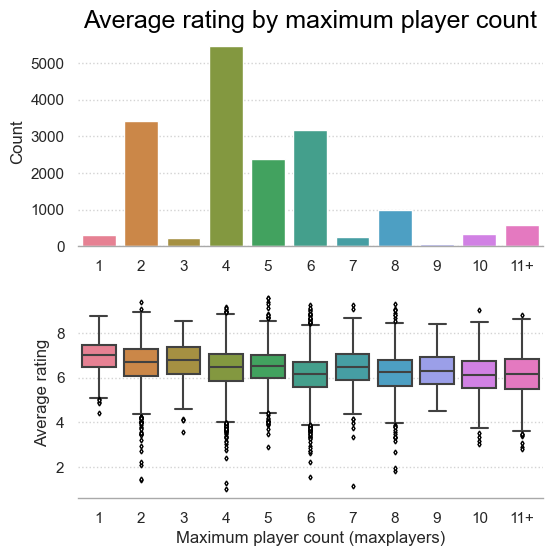

In [75]:


train_details_plot = train_details.copy()
train_details_plot["maxplayers"] = train_details["maxplayers"].apply(lambda x: str(x) if x <= 10 else "11+")

factor_order = [str(i) for i in range(1,11)] + ["11+"]

palette = sns.color_palette("husl", 11)

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : False,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], data = train_details_plot, x = "maxplayers", order = factor_order, palette = palette)
    p2 = sns.boxplot(ax = ax[1], data = train_details_plot,
                     x = "maxplayers",
                     y = "average",
                     order = factor_order, 
                     palette = palette,
                    flierprops = flierprops)
    temp = p1.set(title = "Average rating by maximum player count", xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Maximum player count (maxplayers)", ylabel = "Average rating")

### Playing time


In [ ]:
train_details_plot = train_details.copy()
train_details_plot["playingtime_binned"] = pd.cut(train_details_plot["playingtime"],
                                                 bins = [0, 30, 60, 120, 180, 240, np.inf],
                                                 labels = ["0-30 mins", "30 mins-1hr", "1-2hrs", "2-3hrs", "3-4hrs", "4hrs+"])


fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax = ax.flatten()

p1 = sns.countplot(ax = ax[0], 
              data = train_details_plot, 
              x = "playingtime_binned", 
              palette = sns.color_palette("husl", 6))
p2 = sns.boxplot(ax = ax[1], 
            data = train_details_plot, 
            x = "playingtime_binned", 
            y = "average", 
            palette = sns.color_palette("husl", 6))
temp = p1.set(title = "Average rating by playing time",
      xlabel = "", ylabel = "Count")
temp = p2.set(title = "", xlabel = "Playing time", ylabel = "Average rating")




### Year published

For simplicity, let's also bin the year published variable. The plot below shows average rating by year published, with years after 2000 shown with greater resolution.

As the plot shows, more recent games tend to have higher ratings. This pattern should not necessarily be interpreted to mean that modern games are better, in some objective sense, than older games. The pattern may simply mean that more modern games appeal to modern reviewers, since the rating data is *as of today* and not, for example, as of the game's release. The pattern may also reflect a preference for newness: for example, it is possible that reviewers give higher scores to games that are new *to them* (and which they are therefore excited to play), which translates to newer games getting higher scores on average.

Incidentally, the plot also shows the explosion in boardgame publishing over the past 20 years or so. Over twice as many games were published in the years 2015-19 as were published in the entire 1990s.


In [ ]:

plot_data = train_details.copy()

plot_data["yearpublished_cat"] = pd.cut(plot_data["yearpublished"], right = False,
       bins = [-np.inf, 1990, 2000, 2005, 2010, 2015, 2020, np.inf],
       labels = ["Before 1990", "1990s", "2000-04", "2005-09", "2010-14", "2015-19", "2020-"])


fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax = ax.flatten()

p1 = sns.countplot(ax = ax[0], 
              data = plot_data, 
              x = "yearpublished_cat", 
              palette = sns.color_palette("husl", 7))
p2 = sns.boxplot(ax = ax[1],
                 data = plot_data,
                 x = "yearpublished_cat",
                 y = "average",
                 palette = sns.color_palette("husl", 7))
temp = p1.set(title = "Average rating by year published",
      xlabel = "", ylabel = "Count")
temp = p2.set(title = "", xlabel = "Year published", ylabel = "Average rating")


### Mechanics, Designers, and Publishers



In [ ]:
# split mechanics
import re

def split_out_column(df, col_name, prefix = "cat_", category_threshold = 0):

  def increment_cat_dict(s): # find all unique entries (and create a dict counting the number of games having each mechanic)
    if not isinstance(s, str):
      return

    if s[1] == "'": # entries are either of the ["xx", "yy", ...] or ['xx', 'yy', ...]
      s = re.sub('"', "", s)
      s = s.replace("\\", "") # ignore escaping
      categories = re.findall(r"'([^']+)'", s)
    else:
      s = re.sub("'", "", s)
      s = s.replace("\\", "")
      categories = re.findall(r'"([^"]+)"', s)
    

    for category in categories:  
      if category in cat_dict:
        cat_dict[category] += 1
      else:
        cat_dict[category] = 1

  cat_dict = {}
  df[col_name].apply(increment_cat_dict)

  # Add columns for each dict
  new_df = df.copy()
  for category in cat_dict:

    if cat_dict[category] > category_threshold:
      new_col_name = prefix + category
      new_df[new_col_name] = new_df[col_name].str.contains(category)
      new_df[new_col_name] = pd.to_numeric(new_df[new_col_name], errors = 'coerce', downcast = "integer")

  return new_df


In [ ]:
train_details_mech = split_out_column(train_details, "boardgamemechanic", prefix = "mech_", category_threshold = 15)
train_details_mech

In [ ]:
# find the most common mechanics
# find most common mechs
mech_cols = [x for x in train_details_mech.columns if x.startswith("mech_")]

mech_counts = {}
for col in mech_cols:
  total = train_details_mech[col].sum()
  mech_counts[col] = total

mech_counts_df = pd.DataFrame.from_dict(data = mech_counts, orient = "index", columns = ["count"]).sort_values("count", ascending = False)
mech_counts_df

In [ ]:
n_mechanics = len(mech_counts_df)

topX_mechs = mech_counts_df[:30]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "mech":[]})

overall_average = np.mean(train_details["average"])

for i, mech in enumerate(topX_mechs.index):
  mech = topX_mechs.index[i]
  mech_groupby = train_details_mech.groupby(mech).aggregate(np.mean)["average"].reset_index()
  mech_groupby["mech"] = mech
  mech_groupby = mech_groupby.rename(columns = {mech: "present"})
  all_groupbys = pd.concat([all_groupbys, mech_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["mech"] = all_groupbys["mech"].apply(lambda x: re.split("mech_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)
#print(all_groupbys.sort_values("diff_average"))

fig, ax = plt.subplots(figsize = (10, 10))
p1 = sns.barplot(data = all_groupbys, y = "mech", x = "diff_average")
p1.set(title = "Difference in average rating, by game mechanic",
      xlabel = "Difference in average rating",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for boardgames
    with the corresponding mechanic and the (2) average rating for all boardgames. Only the most 
    common 30 mechanics (out of {n_mechanics}) are shown.
    
"""
ax.annotate(footnote_text, xy = (0.0, -.07), xycoords = "axes fraction", ha = "left", va = "top")
fig.tight_layout()

### Designers



In [ ]:
train_details_designer = split_out_column(train_details,
                                          "boardgamedesigner",
                                          prefix = "dsgnr_",
                                          category_threshold = 10)

In [ ]:
designers = [x for x in train_details_designer if x.startswith("dsgnr_")]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "cat":[]})

overall_average = np.mean(train_details["average"])

for i, col_name in enumerate(designers):
  cat_groupby = train_details_designer.groupby(col_name).aggregate(np.mean)["average"].reset_index()
  cat_groupby["cat"] = col_name
  cat_groupby = cat_groupby.rename(columns = {col_name: "present"})
  
  #print(cat_groupby)

  all_groupbys = pd.concat([all_groupbys, cat_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["cat"] = all_groupbys["cat"].apply(lambda x: re.split("dsgnr_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)



In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
p1 = sns.barplot(data = all_groupbys[:20], y = "cat", x = "diff_average")
p1.set(title = "Difference in average rating, by designer",
      xlabel = "Difference in average rating",
      ylabel = "")

### Publishers

With the publisher variable, we will take a different approach. Allowing all publisher to be data to be used, as we did with designer and mechanic data, risks contaminating the analysis. This is because the exercise we have in mind here is to predict a boardgame's average rating based on intrinsic characteristics of the game. Because  successful games are likely to get multiple editions (especially editions in more and more languages), the set of publishers associated with a boardgame is not an intrinsic characteristic and instead depends (in part) on how successful a boardgame has been. Ideally, we would want to use data on a boardgame's *first* publisher only. However, the *boardgamepublisher* variable includes only a list of publishers and does not provide any way (as far as I can see) to identify a game's first publisher.

To approximate the ideal situation, we will use data on a single randomly chosen publisher per game. For modeling, we will only retain publishers with at least 10 boardgames.

In [ ]:
def reduce_multiple_entries(x):
  if not isinstance(x, str) or len(x) < 3:
    return ""

  if x[1] == "'":
    entries = re.findall(r"'([^']+)'", x)
  else:
    entries = re.findall(r'"([^"]+)"', x)
  
  if len(entries):
    return entries[np.random.randint(len(entries))] # if many, return random
  else:
    print(x)
    return ""

def clean_and_otherize_list_entry(s, threshold):
  # first reduce multiples
  s_new = s.apply(reduce_multiple_entries)

  # otherize publishers with < theshold entries
  s_counts = s_new.value_counts()
  small_entries = s_counts[s_counts < threshold].index.array
  s_new = s_new.apply(lambda x: "Other" if x in small_entries else x)

  return s_new

In [ ]:
publisher_threshold = 10

publisher_clean = clean_and_otherize_list_entry(train_details["boardgamepublisher"], publisher_threshold)

print(publisher_clean.value_counts()) # 313 distinct publishers

train_details_pub = train_details.copy()
train_details_pub["publisher_clean"] = publisher_clean

In [ ]:
top_30_publishers = publisher_clean.value_counts()[:30].index.values

plot_data = train_details_pub[train_details_pub["publisher_clean"].isin(top_30_publishers)]

#plot_data = train_details_pub[]
#plot_data = train_details_pub
len(plot_data)




In [ ]:
by_pub = plot_data.groupby(["publisher_clean"])["average"].agg(np.mean)
by_pub = by_pub.sort_values(ascending = False)
factor_order = by_pub.index


In [ ]:

fig, ax = plt.subplots(figsize = (7, 7))


#p1 = sns.histplot(data = plot_data[plot_data["publisher_clean"] != "Other"], y = "publisher_clean")
p1 = sns.boxplot(data = plot_data, y = "publisher_clean", x = "average", order = factor_order)
temp = p1.set(title = "By publisher",
      xlabel = "Count",
      ylabel = "")